# Use SBERT to Compare a Resume and a Job Description

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
import pandas as pd

In [2]:
from sentence_transformers import SentenceTransformer, util

# Load pre-trained SBERT model (good default: all-mpnet-base-v2)
model = SentenceTransformer('all-mpnet-base-v2')


In [3]:
from utils.convert_to_text import convert_to_text

resume =convert_to_text("test_data/cv.txt")
job_description = convert_to_text("test_data/job.txt")

In [4]:
# Encode both texts
embedding_resume = model.encode(resume, convert_to_tensor=True)
embedding_job = model.encode(job_description, convert_to_tensor=True)

# Compute cosine similarity
cosine_score = util.pytorch_cos_sim(embedding_resume, embedding_job)

print(f"\nCosine Similarity Score: {cosine_score.item():.4f}")

# Optionally, interpret similarity
if cosine_score > 0.75:
    print("✅ Strong match")
elif cosine_score > 0.5:
    print("🤔 Partial match")
else:
    print("❌ Weak match")


Cosine Similarity Score: 0.7611
✅ Strong match


### evaluate a pre-trained SBERT model

In [ ]:
### evaluate a pre-trained SBERT model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import torch
import numpy as np


# Load your dataset
df = pd.read_csv("data/labeled_data.csv")

# Normalize score to [0, 1] range if needed
df['score'] = df['score'] / df['score'].max()

true_scores = []
predicted_scores = []

# Loop through data
for index, row in df.iterrows():
    resume = row['cv_text']
    job = row['offer_text']
    true_score = row['score']

    try:
        # Ensure both are strings
        if isinstance(resume, str) and isinstance(job, str):
            emb_resume = model.encode(resume, convert_to_tensor=True)
            emb_job = model.encode(job, convert_to_tensor=True)
            
            # Compute cosine similarity
            cos_sim = util.pytorch_cos_sim(emb_resume, emb_job).item()
            
            true_scores.append(true_score)
            predicted_scores.append(cos_sim)
    except Exception as e:
        print(f"Skipping row {index} due to error: {e}")
        continue

# Convert to NumPy arrays
true_scores = np.array(true_scores)
predicted_scores = np.array(predicted_scores)



In [19]:

# 📊 Evaluation
mse = mean_squared_error(true_scores, predicted_scores)
mae = mean_absolute_error(true_scores, predicted_scores)
pearson_corr, _ = pearsonr(true_scores, predicted_scores)
spearman_corr, _ = spearmanr(true_scores, predicted_scores)

print("\n📈 Evaluation Results:")
print(f"✅ MSE: {mse:.4f}")
print(f"✅ MAE: {mae:.4f}")
print(f"✅ Pearson Correlation: {pearson_corr:.4f}")
print(f"✅ Spearman Correlation: {spearman_corr:.4f}")



📈 Evaluation Results:
✅ MSE: 0.0304
✅ MAE: 0.1435
✅ Pearson Correlation: 0.5738
✅ Spearman Correlation: 0.5643


# entraînement de SBERT

### 🏁 1. Chargement des données et prétraitement de base

In [12]:
import pandas as pd

# Charger le dataset
df = pd.read_csv("data/labeled_data.csv")

# Normalize score to [0, 1] range if needed
df['score'] = df['score'] / df['score'].max()

In [13]:

# Afficher les premières lignes
df.head()

,offer_text,cv_text,score
0,"Title: Kubernetes Engineer, Senior - Remote\n ...",Résumé: Areas of expertise â¢ Big Data Ecosys...,0.319444
1,Title: Senior Principal Azure Cloud Engineer\n...,Résumé: â Willingness to accept the challeng...,0.208333
2,Title: DevOps Engineer (RHEL)\n Company...,Résumé: CORE COMPETENCIES ~ Ant ~ Maven ~ GIT ...,0.583333
3,Title: Site Reliability Engineer - REST API\n ...,"Résumé: IT SKILLS Languages: C (Basic), JAVA (...",0.583333
4,"Title: Lead Back End Engineer (Java, Spring, G...",Résumé: Education Details \n\n B.C.A Bachelor ...,0.319444


###   Nettoyage de base 


In [14]:
# Supprimer les lignes avec des valeurs nulles
print(f"\nAvant suppression des NaN: {df.shape}")
df = df.dropna()
print(f"Après suppression des NaN: {df.shape}")

# Supprimer les lignes dupliquées
print(f"\nAvant suppression des doublons: {df.shape}")
df = df.drop_duplicates()
print(f"Après suppression des doublons: {df.shape}")



Avant suppression des NaN: (403, 3)
Après suppression des NaN: (401, 3)

Avant suppression des doublons: (401, 3)
Après suppression des doublons: (395, 3)


In [15]:
# Réinitialiser les index
df = df.reset_index(drop=True)

# Vérification finale
print("\n✅ Nettoyage terminé.")
df.head()


✅ Nettoyage terminé.


,offer_text,cv_text,score
0,"Title: Kubernetes Engineer, Senior - Remote\n ...",Résumé: Areas of expertise â¢ Big Data Ecosys...,0.319444
1,Title: Senior Principal Azure Cloud Engineer\n...,Résumé: â Willingness to accept the challeng...,0.208333
2,Title: DevOps Engineer (RHEL)\n Company...,Résumé: CORE COMPETENCIES ~ Ant ~ Maven ~ GIT ...,0.583333
3,Title: Site Reliability Engineer - REST API\n ...,"Résumé: IT SKILLS Languages: C (Basic), JAVA (...",0.583333
4,"Title: Lead Back End Engineer (Java, Spring, G...",Résumé: Education Details \n\n B.C.A Bachelor ...,0.319444


###   2. Petite EDA sur les scores

In [ ]:
from sklearn.model_selection import train_test_split

df['score_bin'] = pd.qcut(df['score'], q=5, labels=False, duplicates='drop')

df, _ = train_test_split(
    df,
    test_size=0.90,  # keep 10%
    stratify=df['score_bin'],
    random_state=42
)
df = df.drop(columns=['score_bin'])
df = df.reset_index(drop=True)


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


 Statistiques sur les scores:
count    39.000000
mean      0.366809
std       0.196927
min       0.166667
25%       0.166667
50%       0.319444
75%       0.583333
max       0.861111
Name: score, dtype: float64


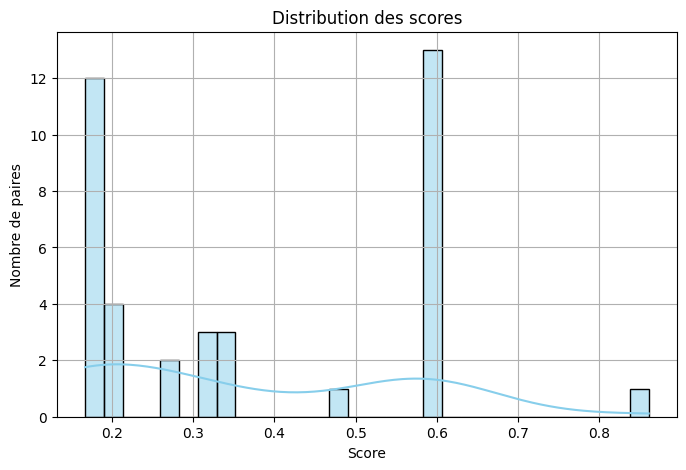

In [27]:
# Statistiques descriptives
print("\n Statistiques sur les scores:")
print(df['score'].describe())

# Distribution des scores
plt.figure(figsize=(8,5))
sns.histplot(df['score'], bins=30, kde=True, color='skyblue')
plt.title('Distribution des scores')
plt.xlabel('Score')
plt.ylabel('Nombre de paires')
plt.grid(True)
plt.show()

In [18]:
# Ajouter 0.1 à tous les scores
# df['score'] = df['score'] + 0.1

In [30]:
df.head()

,offer_text,cv_text,score
33,"title kubernetes engineer, senior remote compa...",r sum technical skills web technologies angula...,0.208333
337,title database administrator company maximus l...,r sum education details hadoop developer hadoo...,0.583333
373,title core strategist company bp energy locati...,"r sum skill set hadoop, map reduce, hdfs, hive...",0.319444
167,title ransomware engineer company fenix24 llc ...,"r sum skill set experience in implementing, an...",0.583333
163,title kafka engineer company compass pointe co...,r sum technical skills programming languages j...,0.166667


### Prétraitement des Textes

In [31]:
import re

def preprocess(text):
    # Mettre tout en minuscule
    text = text.lower()
    
    # Remplacer les retours à la ligne par un espace
    text = text.replace('\n', ' ').replace('\r', ' ')
    
    # Supprimer les caractères spéciaux (garder lettres, chiffres, ponctuations simples)
    text = re.sub(r'[^a-z0-9\s.,;!?]', ' ', text)
    
    # Supprimer les espaces multiples
    text = re.sub(r'\s+', ' ', text)
    
    # Supprimer les espaces au début et à la fin
    text = text.strip()
    
    return text


In [32]:
df['offer_text'] = df['offer_text'].apply(preprocess)
df['cv_text'] = df['cv_text'].apply(preprocess)


In [35]:
df.head()

,offer_text,cv_text,score
0,"title kubernetes engineer, senior remote compa...",r sum technical skills web technologies angula...,0.208333
1,title database administrator company maximus l...,r sum education details hadoop developer hadoo...,0.583333
2,title core strategist company bp energy locati...,"r sum skill set hadoop, map reduce, hdfs, hive...",0.319444
3,title ransomware engineer company fenix24 llc ...,"r sum skill set experience in implementing, an...",0.583333
4,title kafka engineer company compass pointe co...,r sum technical skills programming languages j...,0.166667


In [36]:
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [37]:

# Préparer les exemples pour l'entraînement
train_examples = []

for _, row in df.iterrows():
    offer_text = row['offer_text']
    cv_text = row['cv_text']
    score = float(row['score'])
    
    # Créer un exemple pour SBERT
    train_examples.append(InputExample(texts=[offer_text, cv_text], label=score))

In [38]:

# Diviser les données en jeu d'entraînement et jeu de validation
train_examples, dev_examples = train_test_split(train_examples, test_size=0.1, random_state=42)

###  Load Pretrained SBERT + Regression Loss

In [39]:
# Créer un DataLoader pour l'entraînement
train_dataloader = DataLoader(train_examples, batch_size=16, shuffle=True)
dev_dataloader = DataLoader(dev_examples, batch_size=16)

# Définir la fonction de perte (loss function)
train_loss = losses.CosineSimilarityLoss(model=model)

In [40]:
# Fine-tune for a few epochs
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,
    warmup_steps=100,
    show_progress_bar=True,
    output_path='output/sbert_regression_finetuned'  # Save model here
)


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


### Use  Fine-tuned Model

In [41]:
# from sentence_transformers import SentenceTransformer, util

finetuned_model = SentenceTransformer('output/sbert_regression_finetuned')

# Example inference
resume =convert_to_text("test_data/cv.txt")
job_description = convert_to_text("test_data/job.txt")

# Encode both texts
embedding_resume = finetuned_model.encode(resume, convert_to_tensor=True)
embedding_job = finetuned_model.encode(job_description, convert_to_tensor=True)

# Compute cosine similarity
cosine_score = util.pytorch_cos_sim(embedding_resume, embedding_job)

print(f"\nCosine Similarity Score: {cosine_score.item():.4f}")

# Optionally, interpret similarity
if cosine_score > 0.75:
    print("✅ Strong match")
elif cosine_score > 0.5:
    print("🤔 Partial match")
else:
    print("❌ Weak match")


Cosine Similarity Score: 0.7511
✅ Strong match


### evaluate the fine-tuned SBERT model

In [ ]:
# Load your dataset
df = pd.read_csv("data/labeled_data.csv")

# Normalize score to [0, 1] range if needed
df['score'] = df['score'] / df['score'].max()

true_scores = []
predicted_scores = []

# Loop through data
for index, row in df.iterrows():
    resume = row['cv_text']
    job = row['offer_text']
    true_score = row['score']

    try:
        # Ensure both are strings
        if isinstance(resume, str) and isinstance(job, str):
            emb_resume = model.encode(resume, convert_to_tensor=True)
            emb_job = model.encode(job, convert_to_tensor=True)
            
            # Compute cosine similarity
            cos_sim = util.pytorch_cos_sim(emb_resume, emb_job).item()
            
            true_scores.append(true_score)
            predicted_scores.append(cos_sim)
    except Exception as e:
        print(f"Skipping row {index} due to error: {e}")
        continue

# Convert to NumPy arrays

true_scores = np.array(true_scores)
predicted_scores = np.array(predicted_scores)

In [46]:

# 📊 Evaluation
mse = mean_squared_error(true_scores, predicted_scores)
mae = mean_absolute_error(true_scores, predicted_scores)
pearson_corr, _ = pearsonr(true_scores, predicted_scores)
spearman_corr, _ = spearmanr(true_scores, predicted_scores)

print("\n📈 Evaluation Results:")
print(f"✅ MSE: {mse:.4f}")
print(f"✅ MAE: {mae:.4f}")
print(f"✅ Pearson Correlation: {pearson_corr:.4f}")
print(f"✅ Spearman Correlation: {spearman_corr:.4f}")



📈 Evaluation Results:
✅ MSE: 0.0286
✅ MAE: 0.1378
✅ Pearson Correlation: 0.5950
✅ Spearman Correlation: 0.5859
